In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import math
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import myd2l

In [2]:
class GRUNet(nn.Module):
    def __init__(self, vocab_size, num_hiddens, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.num_directions = 1
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.gru = nn.GRU(vocab_size, num_hiddens)
        self.fc = nn.Linear(num_hiddens, vocab_size)
    
    def forward(self, X, state):
        X = F.one_hot(X.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.gru(X, state)
        Y = self.fc(Y).reshape(-1, self.vocab_size)
        
        return Y, state
    
    def begin_state(self, batch_size, device):
        return torch.zeros((self.num_layers * self.num_directions, batch_size, self.num_hiddens), dtype=torch.float32, device=device)
    

In [3]:
def train_epoch(net, train_iter, loss, optimizer, device, use_random_iter):
    state = None
    start_time, loss_sum, m = time.time(),  0.0, 1
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            state.detach_()

        optimizer.zero_grad()
        X, Y = X.to(device), Y.to(device)
        Y_hat, state = net(X, state)
        l = loss(Y_hat, Y.T.long().reshape(-1))
        l.backward()
        myd2l.grad_clipping(net, 1)
        optimizer.step()

        loss_sum += l.item()
        m += 1
    
    return math.exp(loss_sum / m), m * X.shape[0] * X.shape[1] / time.time() - start_time

In [4]:
def train(net, vocab, train_iter, num_epochs, lr, device, use_random_iter=False):
    net.to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr)

    pred = lambda prefix: myd2l.predict(prefix, num_preds=50, net=net, vocab=vocab, device=device)

    ppls = []
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, optimizer, device, use_random_iter)
        ppls.append(ppl)

        if (epoch + 1) % 10 == 0:
            print(f'epoch {epoch + 1:d}, perplexity {ppl:.1f}')
            print(pred('time traveller'))
        
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.grid(True)
    ax.set_xlabel('epoch')
    ax.set_ylabel('perplexity')
    ax.plot(range(1, num_epochs + 1), ppls)
    plt.show()

    print(f'perplexity {ppl:.1f}, {speed:.1f} examples/sec on {str(device)}')
    print(pred('time traveller'))
    print(pred('traveller'))


epoch 10, perplexity 11.6
time traveller t at t at t at t at t at t at t at t at t at t at
epoch 20, perplexity 9.2
time travellere the the the the the the the the the the the the 
epoch 30, perplexity 8.4
time traveller the the the the the the the the the the the the t
epoch 40, perplexity 7.8
time travellere the the the the the the the the the the the the 
epoch 50, perplexity 7.4
time traveller and the the the the the the the the the the the t
epoch 60, perplexity 7.2
time travellererere the the the the the the the the the the the 
epoch 70, perplexity 6.9
time traveller and the the the the the the the the the the the t
epoch 80, perplexity 6.6
time traveller the the the the the the the the the the the the t
epoch 90, perplexity 6.3
time traveller the the the the the the the the the the the the t
epoch 100, perplexity 6.1
time travellere the there the the the the the the the the the th
epoch 110, perplexity 5.9
time traveller the the the the the the the the the the the the t
epoch 1

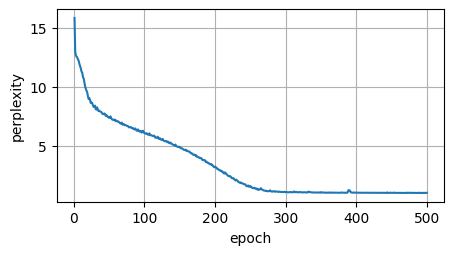

perplexity 1.0, -1731581691.5 examples/sec on cuda
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


In [5]:
batch_size, num_steps = 32, 35
train_iter, vocab = myd2l.load_data_time_machine(batch_size, num_steps)

num_hidden = 256
net = GRUNet(len(vocab), 256)

num_epochs, lr = 500, 1
device = torch.device('cuda')
train(net, vocab, train_iter, num_epochs, lr, device)